## The raw moderated dataset
The raw data is available as [`ndjson`](http://ndjson.org/) files seperated by category, in the following format: 

| Key          | Type                   | Description                                  |
| ------------ | -----------------------| -------------------------------------------- |
| key_id       | 64-bit unsigned integer| A unique identifier across all drawings.     |
| word         | string                 | Category the player was prompted to draw.    |
| recognized   | boolean                | Whether the word was recognized by the game. |
| timestamp    | datetime               | When the drawing was created.                |
| countrycode  | string                 | A two letter country code ([ISO 3166-1 alpha-2](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2)) of where the player was located. |
| drawing      | string                 | A JSON array representing the vector drawing |  


#### Simplified Drawing files (`.ndjson`)
We've simplified the vectors, removed the timing information, and positioned and scaled the data into a 256x256 region. The data is exported in [`ndjson`](http://ndjson.org/) format with the same metadata as the raw format. The simplification process was:

1. Align the drawing to the top-left corner, to have minimum values of 0.
2. Uniformly scale the drawing, to have a maximum value of 255. 
3. Resample all strokes with a 1 pixel spacing.
4. Simplify all strokes using the [Ramer–Douglas–Peucker algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm) with an epsilon value of 2.0.

#### Numpy bitmaps (`.npy`)
All the simplified drawings have been rendered into a 28x28 grayscale bitmap in numpy `.npy` format. The files can be loaded with [`np.load()`](https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.load.html). These images were generated from the simplified data, but are aligned to the center of the drawing's bounding box rather than the top-left corner.

In [1]:
import skimage
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

# Numpy bitmaps

In [2]:
from glob import glob
files = glob("data/numpy_bitmap/*.npy")
files

['data/numpy_bitmap\\ambulance.npy',
 'data/numpy_bitmap\\baseball.npy',
 'data/numpy_bitmap\\beard.npy',
 'data/numpy_bitmap\\bridge.npy',
 'data/numpy_bitmap\\calculator.npy',
 'data/numpy_bitmap\\cat.npy',
 'data/numpy_bitmap\\lightbulb.npy',
 'data/numpy_bitmap\\octopus.npy',
 'data/numpy_bitmap\\smileyface.npy',
 'data/numpy_bitmap\\wristwatch.npy']

In [3]:
# load the data
ambulance = np.load('data/numpy_bitmap/ambulance.npy')
baseball = np.load('data/numpy_bitmap/baseball.npy')
beard = np.load('data/numpy_bitmap/beard.npy')
bridge = np.load('data/numpy_bitmap/bridge.npy')
calculator = np.load('data/numpy_bitmap/calculator.npy')
cat = np.load('data/numpy_bitmap/cat.npy')
lightbulb = np.load('data/numpy_bitmap/lightbulb.npy')
octopus = np.load('data/numpy_bitmap/octopus.npy')
smileyface = np.load('data/numpy_bitmap/smileyface.npy')
wristwatch = np.load('data/numpy_bitmap/wristwatch.npy')

In [4]:
# Add column with label
ambulance = np.c_[ambulance, np.zeros(len(ambulance))]
baseball = np.c_[baseball, np.ones(len(baseball))]
beard = np.c_[beard, 2*np.ones(len(beard))]
bridge = np.c_[bridge, 3*np.ones(len(bridge))]
calculator = np.c_[calculator, 4*np.ones(len(calculator))]
cat = np.c_[cat, np.zeros(len(cat))]
lightbulb = np.c_[lightbulb, np.ones(len(lightbulb))]
octopus = np.c_[octopus, 2*np.ones(len(octopus))]
smileyface = np.c_[smileyface, 3*np.ones(len(smileyface))]
wristwatch = np.c_[wristwatch, 4*np.ones(len(wristwatch))]

In [5]:
# store the label codes in a dictionary
label_dict = {0:'ambulance', 1:'baseball', 2:'beard', 3:'bridge', 4:'calculator',
              5:'cat', 6:'lightbulb', 7:'octopus', 8:'smileyface', 9:'wristwatch'
              }
# store the np.arrays in a list
arrays = [ambulance,baseball,beard,bridge,calculator,cat,lightbulb,octopus,smileyface,wristwatch]

In [6]:
# Examine shape of each category
for k, item in enumerate(arrays):
    print(label_dict[k],'shape: ',item.shape)

ambulance shape:  (148004, 785)
baseball shape:  (135375, 785)
beard shape:  (165202, 785)
bridge shape:  (133010, 785)
calculator shape:  (128375, 785)
cat shape:  (123202, 785)
lightbulb shape:  (120879, 785)
octopus shape:  (150152, 785)
smileyface shape:  (124386, 785)
wristwatch shape:  (162645, 785)


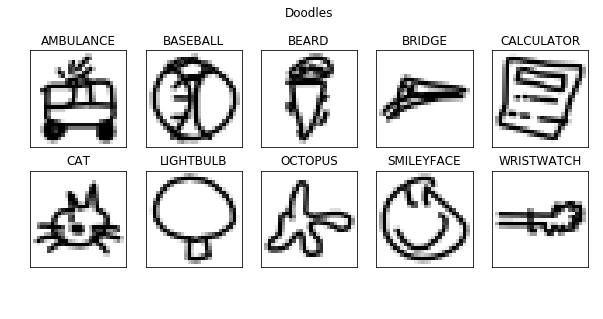

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
plt.subplots_adjust(hspace=-.2)
ax.axis('off')
plt.title('Doodles')
for i, array in enumerate(arrays):
    ax = fig.add_subplot(2,5,i+1)
    plt.title(label_dict[i].upper())
    imgplot = plt.imshow(array[0,:-1].reshape((28,28)), cmap='gray_r', interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

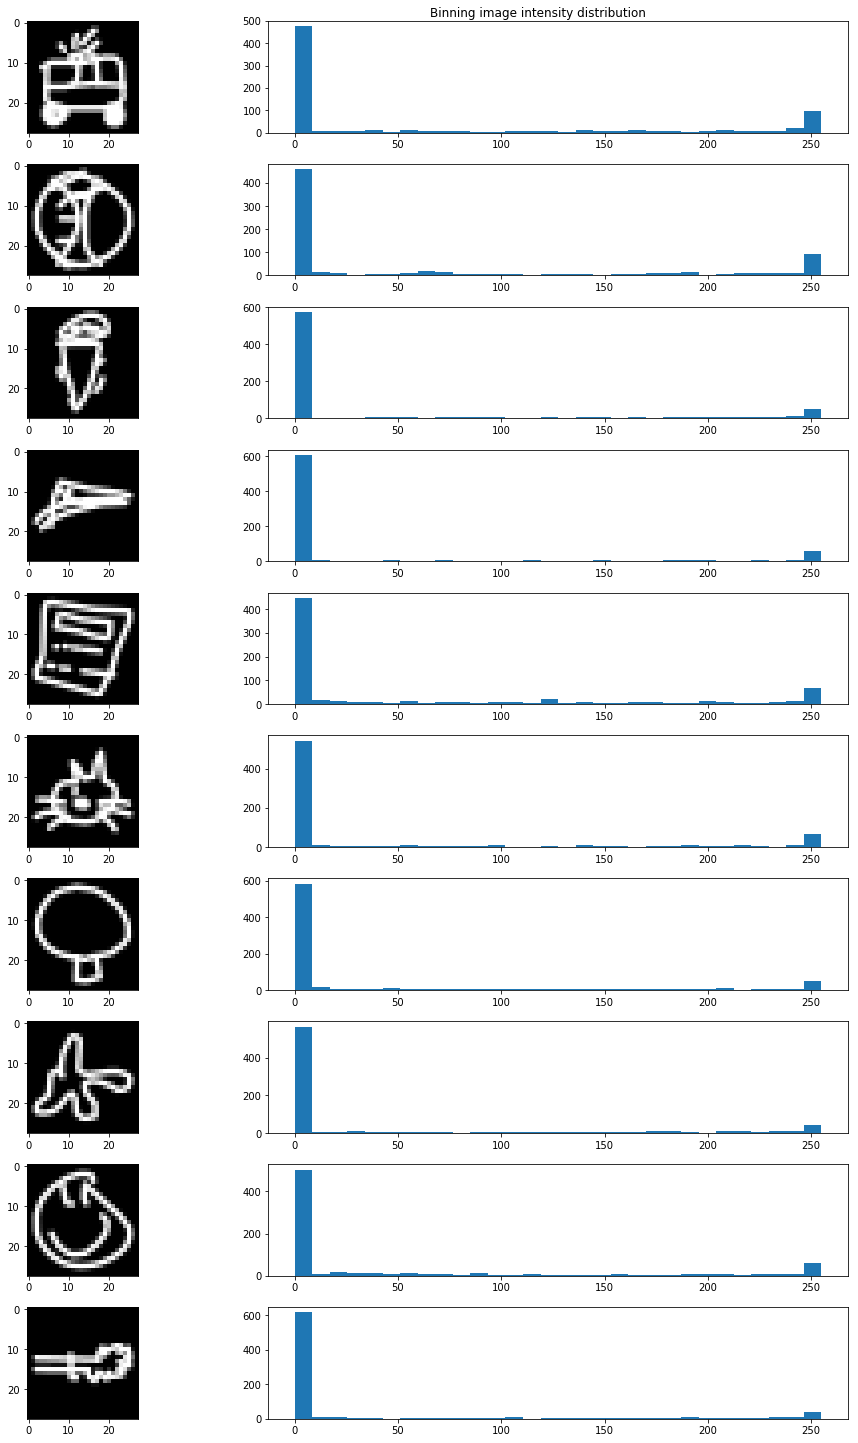

In [8]:
freq = []
bins = []
patches = []

fig, axs = plt.subplots(10, 2, figsize=(15,20))
plt.suptitle('Binning image intensity distribution', x=.7,y=1)
for i, array in enumerate(arrays):
    axs[i,0].imshow(array[0,:-1].reshape((28,28)), cmap="gray")
    a_freq, a_bins, a_patches = axs[i,1].hist(array[0,:-1].reshape((28,28)).flatten(), bins=30,)
    freq.append(a_freq)
    bins.append(a_bins)
    patches.append(a_patches)
plt.tight_layout()

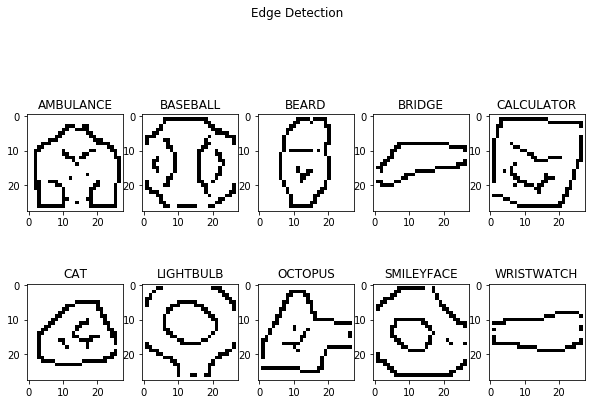

In [11]:
from skimage.feature import canny
fig = plt.figure(figsize=(10,7))
edges = []
plt.suptitle('Edge Detection')
plt.subplots_adjust(hspace=-.2)
for i, array in enumerate(arrays):
    ax = fig.add_subplot(2,5,i+1)
    edge = canny(array[0,:-1].reshape((28,28)), sigma=3)
    plt.imshow(edge, cmap='binary')
    edges.append(edge)
    
    plt.title(label_dict[i].upper())
    

In [12]:
# List of 5000 drawings for each category without label
short_arrays_X = []
# List of 5000 drawings' label for each cateogry
short_arrays_Y = []
for item in arrays:
    short_arrays_X.append(item[:5000,:-1])
    short_arrays_Y.append(item[:5000,-1])
    
X = np.concatenate(short_arrays_X, axis=0).astype('float32')
Y = np.concatenate(short_arrays_Y, axis=0).astype('float32')